In [20]:
!git clone https://github.com/LukeHackett12/MODRL.git
import shutil
shutil.move("/content/MODRL/custom_envs", "/content/custom_envs")
shutil.move("/content/MODRL/dqn_utils", "/content/dqn_utils") 

fatal: destination path 'MODRL' already exists and is not an empty directory.


FileNotFoundError: ignored

In [21]:
!pip install pyvirtualdisplay
!pip install gym --upgrade
!pip install piglet
!pip install pygame 

!apt-get install python-opengl -y
!apt install xvfb -y

Requirement already up-to-date: gym in /usr/local/lib/python3.7/dist-packages (0.18.0)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pl
plt.rcParams['figure.figsize'] = [10, 5]

import numpy as np
from typing import NamedTuple
from collections import deque
from copy import deepcopy
import random
import sys

from numpy.core.numeric import NaN
from custom_envs.mountain_car.engine import MountainCar

import tensorflow as tf
from tensorflow import keras, Tensor
from keras import backend as K

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [23]:
class Transition(NamedTuple):
    currStates: Tensor
    actions: Tensor
    policy: Tensor
    rewards: Tensor
    nextStates: Tensor
    dones: Tensor



class DQNAgent(object):
    def __init__(self, stateShape, actionSpace, numPicks, memorySize, numRewards):
        self.numPicks = numPicks
        self.memorySize = memorySize
        self.replayMemory = deque(maxlen=memorySize)
        self.stateShape = stateShape
        self.actionSpace = actionSpace
        self.numRewards = numRewards

        self.step = 0
        self.sync = 200

        self.alpha = 0.001
        self.walpha = 0.001
        self.delay = 1
        self.epsilon = 1
        self.epsilon_decay = 0.05
        self.epsilon_min = 0.001
        self.eps_threshold = 0

        self.gamma = 0.9
        self.tau = 0.01

        self.train_network = self.createNetwork(stateShape, len(actionSpace), self.alpha)
        self.target_network = self.createNetwork(stateShape, len(actionSpace), self.alpha)

        # Store network weights for each policy
        self.policy_train_weights = [deepcopy(self.train_network.get_weights())] * self.numRewards
        self.policy_target_weights = [deepcopy(self.train_network.get_weights())] * self.numRewards

        # Create and store network weights for W-values
        self.w_network = self.createNetwork(stateShape, numRewards, self.alpha)
        self.wnet_weights = [deepcopy(self.w_network.get_weights())] * self.numRewards

    def createNetwork(self, n_input, n_output, learningRate):
        model = keras.models.Sequential()

        model.add(keras.layers.Dense(24, activation='relu', input_shape=n_input))
        model.add(keras.layers.Dense(48, activation='relu'))
        model.add(keras.layers.Dense(n_output, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learningRate))
        return model

    def trainDQN(self):
        if len(self.replayMemory) <= self.numPicks:
            return [(0, 0)] * self.numRewards

        samples = random.sample(self.replayMemory, self.numPicks)
        batch = Transition(*zip(*samples))
        currStates, actions, policies, rewards, nextStates, dones = batch

        currStates = np.squeeze(np.array(currStates), 1)
        nextStates = np.squeeze(np.array(nextStates), 1)

        rewards = np.array(rewards).transpose().astype(float)
        actions = np.array(actions).reshape(self.numPicks,).astype(int)
        policies = np.array(policies).reshape(self.numPicks,).astype(int)

        dones = np.array(dones).astype(bool)
        notDones = (~dones).astype(float)
        dones = dones.astype(float)

        agentsLoss = []

        for i, reward in enumerate(rewards):
            self.train_network.set_weights(self.policy_train_weights[i])
            self.target_network.set_weights(self.policy_target_weights[i])

            Q_currents_all = self.train_network(currStates, training=False).numpy()
            Q_futures_all = self.target_network(nextStates, training=False).numpy().max(axis=1)

            Q_currents = np.copy(Q_currents_all)
            Q_futures = np.copy(Q_futures_all)

            reward = np.array(reward).reshape(self.numPicks,).astype(float)
            # Q-Learning
            Q_currents[np.arange(self.numPicks), actions] = reward * dones + (reward + Q_futures * self.gamma)*notDones
            lossQ = self.train_network.train_on_batch(currStates,Q_currents)
            self.policy_train_weights[i] = deepcopy(self.train_network.get_weights())

            lossW = 0
            #Leave in exploration actions for now, can remove with "policy[p] != -1"
            inverted_policy_mask = np.array([p for p in range(self.numPicks) if policies[p] != i])
            if len(inverted_policy_mask) > 0:
                # W-Learning
                self.w_network.set_weights(self.wnet_weights[i])
                currStatesNP = currStates[inverted_policy_mask]
                policiesNP = policies[inverted_policy_mask]
                rewardNP = reward[inverted_policy_mask]
                donesNP = dones[inverted_policy_mask]
                notDonesNP = notDones[inverted_policy_mask]

                Q_currents_np = Q_currents_all[inverted_policy_mask].max(axis=1)
                Q_futures_np = Q_futures_all[inverted_policy_mask]

                w_targets = self.w_network(currStatesNP, training=False).numpy()

                # maybe (Q_currents_not_policy - ((rewardNP * donesNP) + (self.gamma * Q_futures_not_policy) * notDonesNP)) * walpha^delay ?
                w_targets[np.arange(len(inverted_policy_mask)), policiesNP] = ((1-self.walpha) * w_targets[np.arange(len(inverted_policy_mask)), policiesNP]) + ((self.walpha**self.delay) * (Q_currents_np - ((rewardNP * donesNP) + (self.gamma * Q_futures_np) * notDonesNP)))
                lossW = self.w_network.train_on_batch(currStatesNP, w_targets)
                self.wnet_weights[i] = deepcopy(self.w_network.get_weights())
            
            agentsLoss.append((lossQ, lossW))

        return agentsLoss

    def selectAction(self, state):
        self.step += 1

        if self.step % self.sync == 0:
            self.policy_target_weights = deepcopy(self.policy_train_weights)
            self.epsilon = max(self.epsilon-self.epsilon_decay, self.epsilon_min)

        emptyPolicies = [0] * self.numRewards
        policy, qs, ws = (-1, emptyPolicies, emptyPolicies)
        random = True
        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            ws = []
            actions = []
            preds = []
            for i in range(self.numRewards):
                self.train_network.set_weights(self.policy_train_weights[i])

                pred = np.squeeze(self.train_network(state, training=False).numpy(), axis=0)
                preds.append(pred)

                action = np.argmax(pred)
                actions.append(action)

                self.w_network.set_weights(self.wnet_weights[i])
                w_val = self.w_network(state, training=False).numpy()[0]
                ws.append(w_val[np.argmax(w_val)])

            policy = np.argmax(ws)
            action = actions[policy]
            qs = preds[policy]
            random = False

        return action, policy, qs, ws, random

    def addMemory(self, memory):
        self.replayMemory.append(memory)

    def save(self):
        save_path = (
            f"./mountain_car_wnet_{int(self.step)}.chkpt"
        )
        #TODO
        print(f"MountainNet saved to {save_path} done!")


In [24]:
class MultiObjectiveWMountainCar(object):
    def __init__(self, episodes):
        self.current_episode = 0
        self.episodes = episodes

        self.episode_score = []
        self.episode_qs = []
        self.episode_height = []
        self.episode_loss = []
        self.episode_ws = []
        self.episode_policies = []

        self.fig, self.ax = plt.subplots(2, 3)
        self.fig.tight_layout()
        self.fig.canvas.draw()
        plt.show(block=False)

        self.numRewards = 3

        self.env = MountainCar(speed=1e8, graphical_state=False,
                               render=False, is_debug=False, random_starts=True)
        self.agent = DQNAgent(stateShape=(
            2,), actionSpace=self.env.get_action_space(), numPicks=32, memorySize=10000, numRewards=self.numRewards)

    def train(self):
        for _ in range(self.episodes):
            self.episode()
            self.current_episode += 1

        self.env.close()

    def episode(self):
        done = False
        rewardsSum = 0
        
        lossSums = [0] * (self.numRewards)
        policies = [0] * (self.numRewards)
        qSums = [0] * (self.numRewards)
        wSums = [0] * (self.numRewards)
        actions = 1

        state = self.env.reset().reshape(1, 2)
        maxHeight = -1

        while not done:
            action, policy, qs, ws, random = self.agent.selectAction(state)
            if not random:
                policies[policy] += 1
                qSums = [qSums[i] + qs[i] for i in range(len(policies))]
                wSums = [wSums[i] + ws[i] for i in range(len(policies))]
                actions += 1

            #print("{} action taken by {} policy, q-val: {}, w-val: {}".format(Action(action).name, Policy(policy).name,q,w))

            obs, reward, done, total_score = self.env.step_all(action)

            maxHeight = max(obs[0], maxHeight)
            if obs[0] >= 0.5:
                reward = [r+10 for r in reward]

            nextState = obs.reshape(1, 2)
            rewardsSum = np.add(rewardsSum, sum(reward))

            loss = self.agent.trainDQN()
            self.agent.addMemory((state, action, policy, reward, nextState, done))
            state = nextState
            lossSums = [lossSums[i] + loss[i][0] for i in range(len(policies))]

        if (total_score < 200) and self.current_episode > 150:
            self.agent.save()

        self.episode_score.append(rewardsSum)
        self.episode_height.append(maxHeight)
        self.episode_loss.append(lossSums)
        self.episode_policies.append(policies)
        self.episode_qs.append([qSum/actions for qSum in qSums])
        self.episode_ws.append([wSum/actions for wSum in wSums])
        self.plot()

        print("now epsilon is {}, the reward is {} with loss {} in episode {}".format(
            self.agent.epsilon, rewardsSum, lossSums, self.current_episode))
        print("Report: \nrewardSum:{}\nheight:{}\nloss:{}\npolicies:{}\nqAverage:{}\nws:{}".format(self.episode_score[-1],
                                                                                                  self.episode_height[-1],
                                                                                                  self.episode_loss[-1],
                                                                                                  self.episode_policies[-1],
                                                                                                  self.episode_qs[-1],
                                                                                                  self.episode_ws[-1]))


    def plot(self):
        plt.figure(2)
        self.fig, self.ax = plt.subplots(2, 3)
        self.fig.tight_layout()
        self.fig.canvas.draw()

        self.ax[0][0].title.set_text('Score')
        self.ax[0][0].plot(self.episode_score, 'b')

        self.ax[0][1].title.set_text('Height')
        self.ax[0][1].plot(self.episode_height, 'g')

        policies = np.transpose(self.episode_policies)
        colors = pl.cm.jet(np.linspace(0, 1, len(policies)))

        self.ax[0][2].clear()
        self.ax[0][2].title.set_text('Loss')
        losses = np.transpose(self.episode_loss)
        for i, loss in enumerate(losses):
            self.ax[0][2].plot(loss, color=colors[i], label=i)
        self.ax[0][2].legend()

        self.ax[1][0].clear()
        self.ax[1][0].title.set_text('Policy Choices')
        for i, policy in enumerate(policies):
            self.ax[1][0].plot(policy, color=colors[i], label=i)
        self.ax[1][0].legend()

        self.ax[1][1].clear()
        self.ax[1][1].title.set_text('Q-Val')
        qs = np.transpose(self.episode_qs)
        for i, q in enumerate(qs):
            self.ax[1][1].plot(q, color=colors[i], label=i)
        self.ax[1][1].legend()

        self.ax[1][2].clear()
        self.ax[1][2].title.set_text('W-Val')
        ws = np.transpose(self.episode_ws)
        for i, w in enumerate(ws):
            self.ax[1][2].plot(w, color=colors[i], label=i)
        self.ax[1][2].legend()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.pause(0.001)  # pause a bit so that plots are updated


<Figure size 720x360 with 0 Axes>

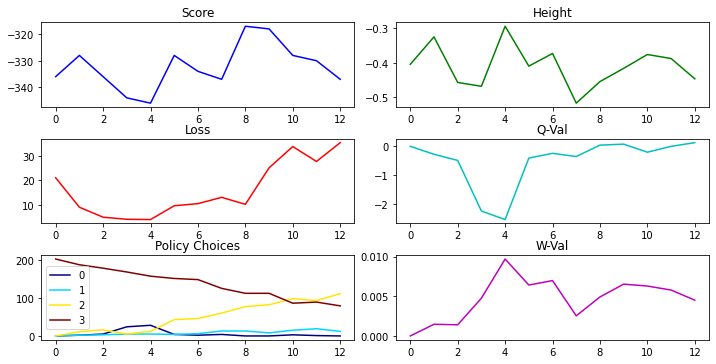

Report: 
rewardSum:-337
qAverage:0.1287893347081638
height:-0.44639075691781427
loss:35.41157548909541
policies:[0, 12, 111, 79]
dones:0.004508393179182143


In [ ]:
agent = MultiObjectiveWMountainCar(2000)
agent.train()

In [ ]:
from google.colab import files
!zip -r /content/mountain_car_tfngmo_99905.chkpt.zip /content/mountain_car_tfngmo_99905.chkpt
files.download('mountain_car_tfngmo_99905.chkpt.zip') 